## Import Dependencies

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2022-02-08 14:00:58.623683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/osboxes/projects/faceid/faceid/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-08 14:00:58.623806: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Creating Folder Structures

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

### Moving LWF images to Negative folder

In [5]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collect Positive and Anchor classes

In [4]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Image collection', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

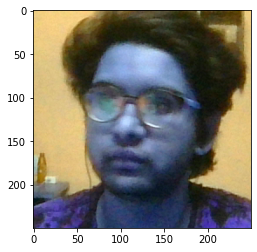

In [9]:
plt.imshow(frame[120:120+250, 200:200+250, :])

## Preprocessing the images

In [4]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-02-08 09:22:52.439830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/osboxes/projects/faceid/faceid/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-08 09:22:52.439903: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 09:22:52.440010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (osboxes): /proc/driver/nvidia/version does not exist
2022-02-08 09:22:52.506950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
dir_test = anchor.as_numpy_iterator()

In [27]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img/255.0
    return img

### Creating labelled Dataset

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [7]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [8]:
data = data.map(preprocess_twin)

In [9]:
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [10]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Engineering

### Build Engineering Layer

In [4]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name = 'input_img')
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [5]:
embedding = make_embedding()

2022-02-08 14:02:05.206459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/osboxes/projects/faceid/faceid/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-08 14:02:05.206706: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 14:02:05.206771: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (osboxes): /proc/driver/nvidia/version does not exist
2022-02-08 14:02:05.235147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Build Distance Layer

In [6]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### Make Siamese Model

In [7]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    siamese_layer = L1Dist()
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs = [classifier], name = 'SiameseNetwork')

In [8]:
siamese_model = make_siamese_model()

## Training

 ### Setup Loss and Optimizer

In [9]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [10]:
opt = tf.keras.optimizers.Adam(1e-4)

### Establish Checkpoints

In [19]:
checkpoint_dir = './training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

### Build Train Step Function

In [11]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

### Build Training Loop

In [12]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [32]:
EPOCHS = 5

In [33]:
train(train_data, EPOCHS)


 Epoch 1/5
27/27 [==============================] - 831s 30s/step

 Epoch 2/5
27/27 [==============================] - 853s 32s/step

 Epoch 3/5
27/27 [==============================] - 807s 30s/step

 Epoch 4/5
27/27 [==============================] - 768s 28s/step


## Evaluate Model

In [34]:
from tensorflow.keras.metrics import Precision, Recall

In [35]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [37]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.9958062e-01],
       [2.7120045e-08],
       [1.5050400e-05],
       [9.9914873e-01],
       [6.8980187e-02],
       [2.9256373e-07],
       [1.5692137e-06],
       [5.0458312e-04],
       [9.9988574e-01],
       [9.7231805e-01],
       [3.9392710e-04],
       [9.9050862e-01],
       [5.5293617e-06],
       [1.7650844e-07],
       [6.2408447e-03],
       [7.2759690e-08]], dtype=float32)

In [38]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [39]:
y_true

array([1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

## Metrics

In [40]:
m_1 = Recall()
m_1.update_state(y_true, y_hat)
m_1.result().numpy()

1.0

In [42]:
m_2 = Precision()
m_2.update_state(y_true, y_hat)
m_2.result().numpy()

1.0

## Saving the Model

In [43]:
siamese_model.save('siamesemodel.h5')

In [13]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                           custom_objects = {'L1Dist' : L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [14]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## Real Time test

## Verification Test

In [35]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_data')):
        input_img = preprocess(os.path.join('application_data', 'input_data', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_data', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_data')))
    verified = verification > verification_threshold
    
    return results, verified

## OpenCV Real Time Verification

In [39]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_data', 'input_image.jpg'), frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [44]:
results, verification = verify(model, 0.9, 0.5)
print(verification)

True
